In [1]:
## The Wonderful World of ML - Session 3 Assignment (Linear Regression)

In addition to the references provided in session 2, I've uploading all the video and course notes from the [**Regression Models**](https://www.coursera.org/learn/regression-models) class from the Johns Hopkins Data Science Specialization on coursera to our meetup repo [here](https://github.com/focods/WonderfulML/tree/master/docs/JHU_DSS_RegMods).  This weeks assignment is adapted from an assignment given in this class.

If you haven't done so by now, install jupyter notebook and configure it with an R kernel if you are an R user.  If you are Python user, your Anaconda install will have Python configured out of the box.  For further details, refer to the top of the session 2 notebooks.

### Only one problem for this session, but it's a good one...

2) What was the cost function Sondra mentioned that is used for linear regression?

The data for this assignment can be found in our meetup repo:

[https://raw.githubusercontent.com/focods/WonderfulML/master/data/mtcars.csv](https://raw.githubusercontent.com/focods/WonderfulML/master/data/mtcars.csv)

**Here is the scenario:**  *You work for Motor Trend, a magazine about the automobile industry. Looking at a data set of a collection of cars, they are interested in exploring the relationship between a set of variables and miles per gallon (MPG) (outcome). They are particularly interested in the following two questions:*

1. Is an automatic or manual transmission better for MPG?  
2. Quantify the MPG difference between automatic and manual transmissions.

Here is some code to get you started.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

mtcars = pd.read_csv("https://raw.githubusercontent.com/focods/WonderfulML/master/data/mtcars.csv")
mtcars.head()

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


Let's do a little EDA...

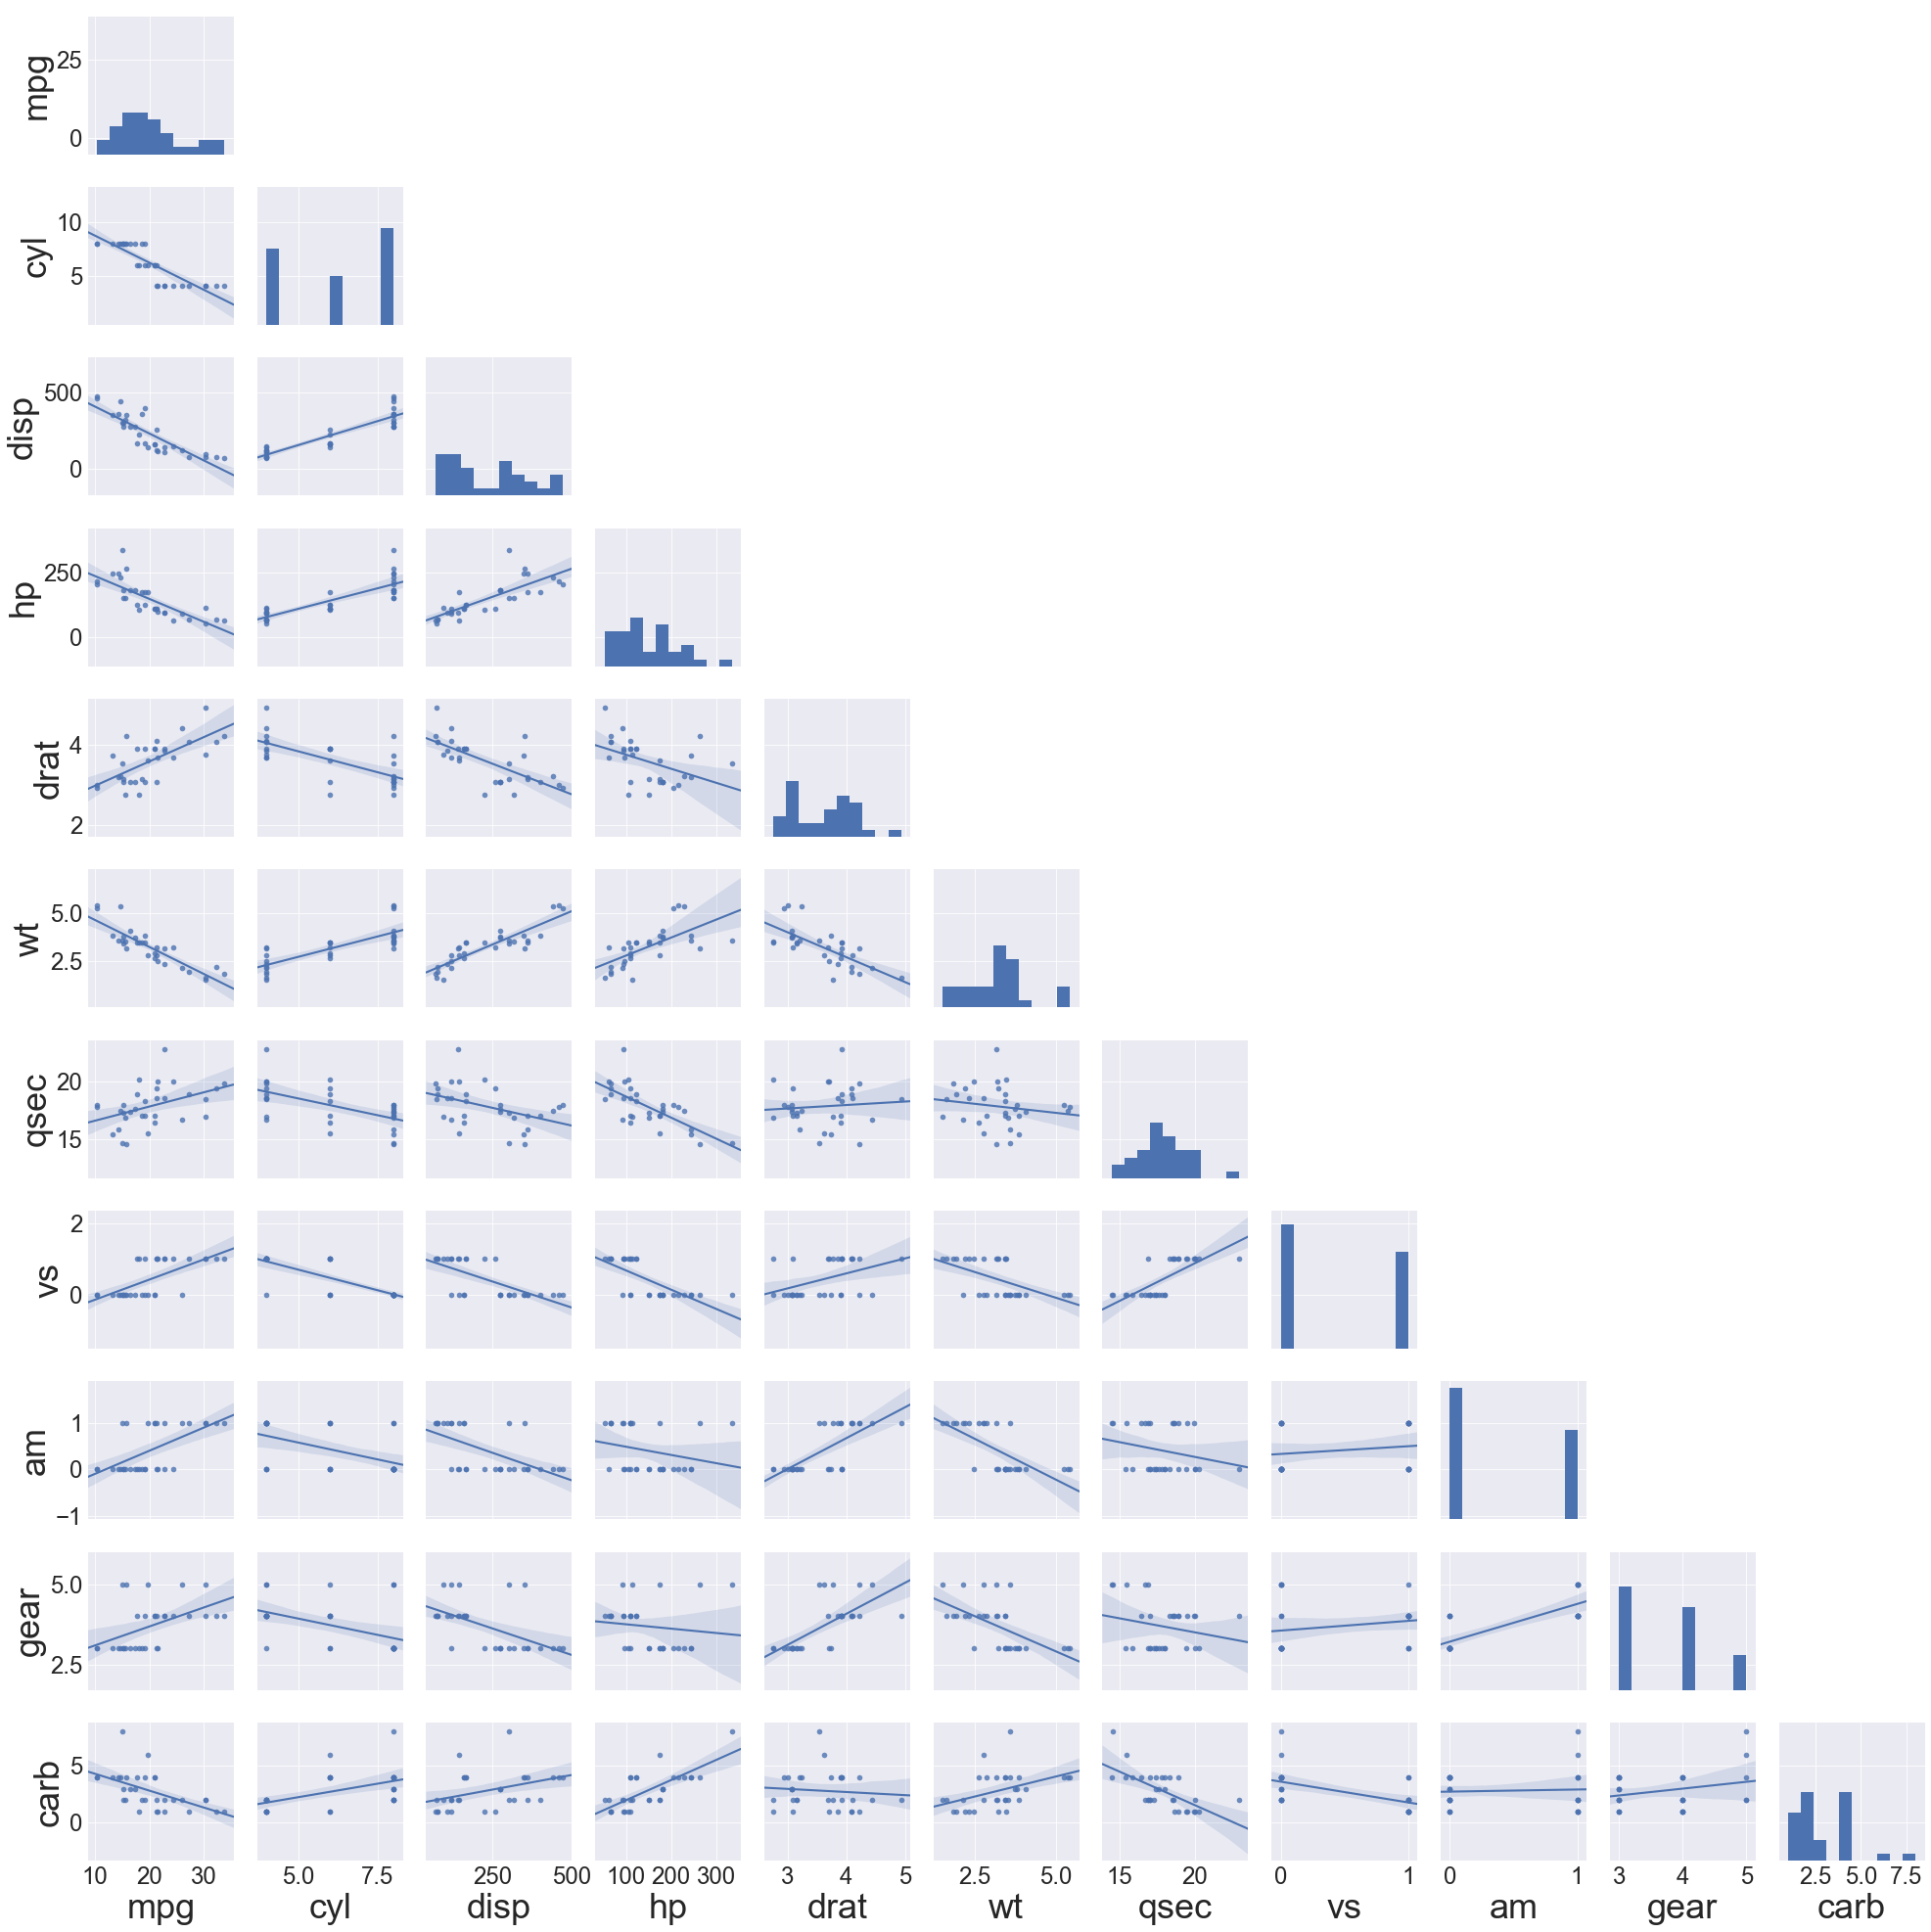

In [3]:
# https://stackoverflow.com/questions/42592493/displaying-pair-plot-in-pandas-data-frame
# Not as nice as the R Pairs plot from GGally library, but get's us going...
#pd.plotting.scatter_matrix(mtcars, figsize=(15, 15), marker='o',
#                           hist_kwds={'bins': 20}, s=60, alpha=.8);
#plt.suptitle('Figure 1: Pairs Plot of Variables in mtcars Dataset',
#             fontsize=18, fontweight='bold')
#plt.show()
import seaborn as sns

sns.set_context("paper", rc={"axes.labelsize":36, "xtick.labelsize":24, "ytick.labelsize":24})
p1 = sns.pairplot(mtcars, kind='reg', diag_kind='hist') #, hue = 'am'),
#                  vars = ['mpg', 'cyl', 'disp', 'hp', 'drat', 'wt', 'qsec', 'vs', 'gear', 'carb'])
# remove upper triangular plots because they are redundant
# https://stackoverflow.com/questions/34087126/plot-lower-triangle-in-a-seaborn-pairgrid
for i, j in zip(*np.triu_indices_from(p1.axes, 1)):
    p1.axes[i, j].set_visible(False)

sns.plt.show()

Let's take a look at the overall effect of transmission on MPG with this question in mind: *Is an automatic or manual transmission better for MPG?*  

Let's start by taking a look at a box plot comparing all the automatics against all the manual transmissions:

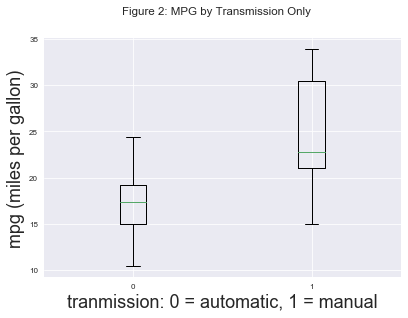

In [4]:
auto_cars = mtcars.loc[mtcars['am'] == 0, 'mpg']
man_cars = mtcars.loc[mtcars['am'] == 1, 'mpg']
sns.set_context("paper", rc={"axes.labelsize":18})  # reset label size
fig = plt.figure()
fig.suptitle('Figure 2: MPG by Transmission Only')
ax = fig.add_subplot(111)
# ; or plt.show() hides before plot output https://stackoverflow.com/questions/25790062/
ax.boxplot([auto_cars, man_cars], labels=('0', '1'))

ax.set_ylabel("mpg (miles per gallon)")
ax.set_xlabel("tranmission: 0 = automatic, 1 = manual")

plt.show()

The plot suggests that manuals get better mileage than automatics. Let's see if a t-test confirms this:

In [5]:
import scipy.stats as sp
t, p = sp.ttest_ind(auto_cars, man_cars, equal_var=False)
print("t = {}, p-value = {}".format(t, p))

t = -3.767123145144923, p-value = 0.0013736383330710345


O.k., if we assume that other factors are **not** confounding our results, then the data suggests that manuals give better mileage.  So our next task is to check for factors that may be confounding the results keeping in mind that our goal is to create an *appropriate* linear model which focused on the effects of transmission (**am**), **not** to create a model that best predicts MPG from the dataset.

An *appropriate* model for this goal was considered to be one that accurately quantified the effects of transmission on MPG (**mpg**) with only the required number of variables. Based on our initial assumption, the process of model selection should start by first building the simpliest possible model which is just the mean **mpg**.  This **f00** model will be our *reference*.

The next simpliest model will again use **mpg** as the response, but include the **am** variable as a predictor.  This **f01** model will be our *base*.

#### Important note here: We will use the entire dataset for this analysis because we are focusing on *characterization* of transmission on mpg rather than on prediction.

In [6]:
import statsmodels.api as sm
f00 = mtcars['mpg'].mean(axis=0)
f01 = sm.OLS(mtcars['mpg'], sm.add_constant(mtcars['am']))
res01 = f01.fit()
print(res01.summary())  # same results as lm in R:  

C:\apps\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     16.86
Date:                Sat, 22 Jul 2017   Prob (F-statistic):           0.000285
Time:                        15:23:16   Log-Likelihood:                -95.242
No. Observations:                  32   AIC:                             194.5
Df Residuals:                      30   BIC:                             197.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.1474      1.125     15.247      0.0

In [7]:
# https://stats.stackexchange.com/questions/292618/how-do-i-do-an-f-test-to-compare-nested-linear-models-in-python
# Could write my own functions to do this, but would rather use existing api's...

$$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\Yv}{\mathbf{Y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\betav}{\mathbf{\beta}}
\newcommand{\gv}{\mathbf{g}}
\newcommand{\Hv}{\mathbf{H}}
\newcommand{\dv}{\mathbf{d}}
\newcommand{\Vv}{\mathbf{V}}
\newcommand{\vv}{\mathbf{v}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\Sv}{\mathbf{S}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\Zv}{\mathbf{Z}}
\newcommand{\Norm}{\mathcal{N}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}
\newcommand{\dimensionbar}[1]{\underset{#1}{\operatorname{|}}}
\newcommand{\dimensionbar}[1]{\underset{#1}{\operatorname{|}}}
\newcommand{\grad}{\mathbf{\nabla}}
\newcommand{\ebx}[1]{e^{\wv_{#1}^T \xv_n}}
\newcommand{\eby}[1]{e^{y_{n,#1}}}
\newcommand{\Tiv}{\mathbf{Ti}}
\newcommand{\Fv}{\mathbf{F}}
\newcommand{\ones}[1]{\mathbf{1}_{#1}}
$$

## The Wonderful World of ML - Session 3 Discussion: Logistic Regression

<img src="https://raw.githubusercontent.com/MichaelSzczepaniak/WonderfulML/master/docs/graphics/child_on_logistic_curve_70per.jpg">

Logistic regression provides a straightforward way to model the probability that one of two mutually exclusive outcomes will occur. This is another way of saying that this is a technique used for **binary classification**. Because this is one of the simplest and most popular classifiers out there, this should be in every machine learning practicioners toolbox.  It also serves as a good starting point for more sophisticated classification techniques such as LDA and QDA which we'll cover in the next session.

What are some examples of binary classification?
+ Will a team win or loss a game?
+ Will a customer buy or not buy?
+ Will a person survive 90 days after a myocardial infarction (heart attack)?
+ Will a passenger survive the Titanic disaster? (kaggle competition)

### What is logistic regression modeling?

At first look, it may seem odd to call this classifier logistic *regression* until you realize that this technique is modeling the underlying conditional probability of an event occuring given one or more predictors.  In other words, we are fitting a function to $p(C_n=k\,|\, \xv_n)$ where $C_n=\text{class of } n^\text{th}\text{ sample}$ which is binary,  meaning that k can only be 0 or 1.  The term $\xv_n$ is a vector of predictors for the $n^{th}$ sample.

### How is this model constructed?

A natural way to think about modeling a probablity is to divide the count of an event by the total number of events.  Let's start by proposing a function $f(\xv;\wv_k)$ that is proportional to the count or frequency of a given event $k$.  With our $f(\xv;\wv_k)$ as a function of our predictors $\xv$ and some weight parameters $\wv_k$ for each class, we can use this to compute probabilities by dividing $f(\xv;\wv_k)$ for a particular class $k$ by the total count in all classes which can be expressed as:

1.$$
    \begin{align*}
      p(C=k|\xv) = \frac{f(\xv;\wv_k)}{\sum_{m=1}^K f(\xv;\wv_m)} = g_k(\xv)
    \end{align*}
$$

The above ensures that $p(C=k|\xv)$ will be between 0 and 1 if $f(\xv;\wv_k) \gt 0$, but we have another contraint which is:

2.$$
      \begin{align*}
      1  = \sum_{k=1}^K p_k(C=k|\xv) = \sum_{k=1}^K g_k(\xv)
      \end{align*}
$$

If we look closely at this equation 2., we notice that this really gives us only $(k-1)$ contraints on $g_k(\xv)$ because we can always determine one these contraints by subtracting 1 from the sum of the other.  In other words, for some arbitrary $g_m(\xv)$ where $m \ne k$, we can write:

3.$$
      \begin{align*}
      g_m(\xv) = 1 - \sum_{k=1, k \ne m}^K g_k(\xv)
      \end{align*}
$$

So, we'll just set the final $f(\xv;\wv_k)$, for $k=K$, to be 1.  This gives us:

4.$$
      \begin{align*}
        g_k(\xv) = \left \{ \begin{array}{ll}
            \dfrac{f(\xv;\wv_k)}{1+\sum_{m=1}^{K-1} f(\xv;\wv_m)}, & k < K\\
            \dfrac{1}{1+\sum_{m=1}^{K-1} f(\xv;\wv_m)}, & k = K
          \end{array}
        \right .
      \end{align*}
$$

Since we are only considering two classes, we can drop the subscript $k$ and write:

5.$$
      \begin{align*}
        g(\xv) = \dfrac{f(\xv;\wv)}{1+f(\xv;\wv)}
      \end{align*}
$$

So how do we select $f(\xv;\wv)$?  As it turns out, selecting $f(\xv;\wv) = e^{\wv^T \xv}$ allows us to more easily evaluate the gradient of the log-likelihood function which is used to find the best fit parameters which we'll touch on in the next section below.  For now, we'll just point out that selecting our $f(\xv;\wv)$ in this way results in the *logisitic function* shown in equation (4.2) in the ISL and more generally below:

6.$$
      \begin{align*}
        g(\xv) = \dfrac{e^{\wv^T \xv}}{1+e^{\wv^T \xv}} = p(C=k|\xv)
      \end{align*}
$$

If you play with 6. a little, you can easily convince yourself that this is the same function as $sigmoid(x) = \dfrac{1}{1+e^{-\wv^T \xv}}$.  Leaving 6. in the form of the logistic function allows us to more easily see that with a little manipulation, we can rewrite 6. in terms of the *odds* or *odds ration* as:

7.$$
      \begin{align*}
        \frac{p(C=k|\xv)}{1 - p(C=k|\xv)} = e^{\wv^T \xv} = \text{odds or odds ratio}
      \end{align*}
$$

If we take the natural log of both sides of 7., we get a more general form of what is shown as equation (4.4) in the ISL.

8.$$
      \begin{align*}
        \ln{\Big(\frac{p(C=k|\xv)}{1 - p(C=k|\xv)}\Big)} = \wv^T \xv
      \end{align*}
$$

The left side of 8. is referred to as the *log-odds* or *logit* and we can see clearly that the model assumes that this quantity is linear in the predictors $\xv$.

### How do we find the best parameters for the model?

The most common way to solve for our parameters is to *maximize the likelihood* of our model fit to the data.  *What is the likelihood?*  The likelihood is just the product of all $p(C=\text{class of }
n^\text{th}\text{ sample}\,|\,\xv_n)$ values for sample $n$.  A common way to express this product is

9.$$
    \begin{align*}
      L(\wv) = \prod_{n=1}^N \prod_{k=1}^K p(C=k\,|\, \xv_n)^{t_{n,k}}
    \end{align*}
$$


What's that $t_{n,k}$ term in 9. mean?  This is referred to as a *binary indicator variable* which can only take on the values of 1 or 0. $t_{n,k}$ is 1 when $k$ is the correct (target) class and 0 at all other values of $k$.  For example, say we have three classes ($K=3$) and training sample $n$ is from Class 2, then the  product is

$$
      \begin{align*}
        p(C=1\,|\,\xv_n)^{t_{n,1}} p(C=2\,|\,\xv_n)^{t_{n,2}}
        p(C=3\,|\,\xv_n)^{t_{n,3}} & = 
         p(C=1\,|\,\xv_n)^0 p(C=2\,|\,\xv_n)^1 p(C=3\,|\,\xv_n)^0 \\
        & = 1\; p(C=2\,|\,\xv_n)^1 \; 1 \\
        & = p(C=2\,|\,\xv_n) 
      \end{align*}
$$

This shows how the indicator variables as exponents select the correct terms to be included in the product.

Now that we know what our object function is, we can turn our attention to finding $\wv$ that maximizes the data likelihood.  How should we proceed?

Right.  Find the derivative of 9. with respect to each component of $\wv$, or the gradient with respect to $\wv$.  But there is a mess of products in this. So let's make this easier by working with the natural logarithm  $\ln\Big( L(\wv)\Big)$ which we will call $LL(\wv)$.

10.$$
    \begin{align*}
      LL(\wv) = \ln\Big( L(\wv) \Big) = \sum_{n=1}^N \sum_{k=1}^K t_{n,k}  \log p(C=k\,|\,\xv_n)
    \end{align*}
$$

Since $LL(\wv)$ is not linear in $\wv$, we need to solve 10. iteratively using gradient **ascent**, that is stepping up the gradient because we are **maximizing** our log-likelihood objective function as opposed to minimizing a *cost* function like we did for linear regression.

The procedure is

  * Initialize $\wv$ to some value.
  * Make small change to $\wv$ in the direction of the  gradient of $LL(\wv)$ with respect to $\wv$  (or $\grad_{\wv} LL(\wv)$)
  * Repeat above step until $LL(\wv)$ seems to be at a maximum.

$$
      \begin{align*}
        \wv \leftarrow \wv + \alpha \grad_{\wv} LL(\wv)
      \end{align*}
$$

where $\alpha$ is a constant that affects the step size.

Deriving the expression for the gradient and the details regarding the update rules gets a bit involved, so for those that are interested, I describe these details in [this notebook (not available yet...)]().

### What tools are available in Python to do logistic regression?

For you Python folks, tool selection is a bit more complicated than for the R folks.  From my very limited research, the two more popular packages that folks tend to use are [scikit-learn](http://scikit-learn.org/stable/index.html) (sklearn package) and [statsmodels](http://www.statsmodels.org).  They each have their strengths and weakness as described [here for linear regression](https://becominghuman.ai/stats-models-vs-sklearn-for-linear-regression-f19df95ad99b).

Sklearn implements **regularization** which we have not discussed yet, but is an important consideration.  There doesn't seem to be a way to turn off regularization directly through sklearn, but you can set the inverse regularization parameter to a very high value (e.g. 1e9) which should have the same effect as turning of regularization.  To understand why, [this video explains the general concept of regularization quite well](https://www.youtube.com/watch?v=KvtGD37Rm5I).  Keep in mind that this the example described here is for L2 regularization (aka *ridge* regression vs. lasso which is L1 regularization)

### How do we handle discrete and continuous variables in our model?